In [1]:
%matplotlib notebook

In [2]:
from sys import path
import splipy as sp
from splipy import curve_factory
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Car turning

We model a tiny roadpiece consisting of a straight line going from (1,-1) to (1,0) followed by a circular turn. We can create this curve using the following code

<IPython.core.display.Javascript object>


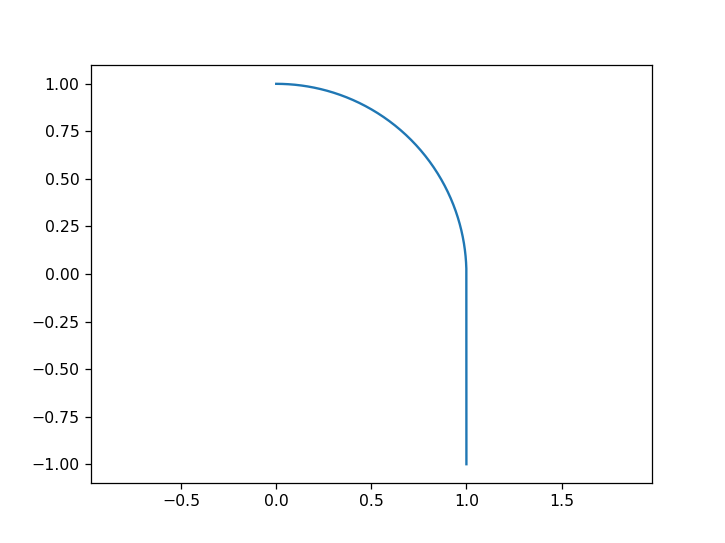

(-0.04999999999999993, 1.05, -1.1, 1.1)

In [17]:
straight_piece = curve_factory.line([1,-1], [1,0])
curve_piece = curve_factory.circle_segment(r=1, theta=np.pi/2)
road = straight_piece.append(curve_piece)

t = np.linspace(c1.start(0), c1.end(0), 360)
x = c1(t)
plt.figure()
plt.plot(x[:,0], x[:,1])
plt.axis('equal')

However this is terrible road design since it will create awfull driving conditions. The best way to see this is by looking at the acceleration vector. We can plot both the velocity and the acceleration by a call to  `.derivative()` with respectively 1st and 2nd order derivative. This is shown in the code below along with a simple animation of this.

<IPython.core.display.Javascript object>


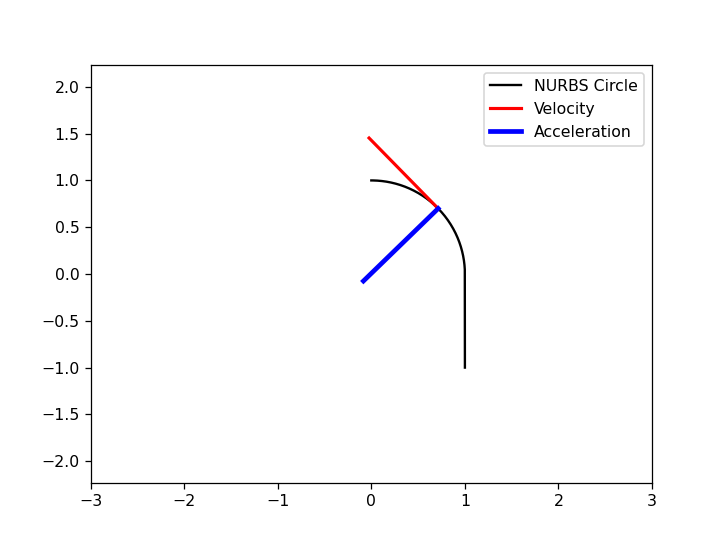

In [19]:
t = np.linspace(road.start(0), road.end(0), 250)# parametric evaluation points
x = road(t)                                     # physical (x,y)-coordinates, size (n,2)
v = road.derivative(t, 1)                       # velocity at all points
a = road.derivative(t, 2)                       # acceleration at all points

# plot the circle and get reference to the acceleration/velocity lines which we
# will update during animation
fig = plt.figure()
plt.plot(x[:,0], x[:,1], 'k-')
velocity,     = plt.plot([x[0,0], x[0,0]+v[0,0]], [x[0,1], x[0,1]+v[0,1]], 'r-', linewidth=2)
acceleration, = plt.plot([x[0,0], x[0,0]+a[0,0]], [x[0,1], x[0,1]+a[0,1]], 'b-', linewidth=3)
plt.axis('equal')
plt.legend(('NURBS Circle', 'Velocity', 'Acceleration'))

# update the velocity/acceleration lines for frame *i* in the animation
def animate(i):
    velocity.set_data(    [x[i,0], x[i,0]+v[i,0]], [x[i,1], x[i,1]+v[i,1]])
    acceleration.set_data([x[i,0], x[i,0]+a[i,0]], [x[i,1], x[i,1]+a[i,1]])
    plt.axis([-3, 3, -3, 3])
    
# create and show the animation
ani = animation.FuncAnimation(fig, animate, np.arange(1,n), interval=24)
plt.show()

# Question 1
The acceleration vector really isn't the right thing to plot here. What we look at is the steering whell of the car which for straight section is fixed in place straight ahead and for the curved section is fixed in place for a turn. The change between these two states have zero measure. While the second derivative (acceleration) is related to the steering whell, it is not really equal. See if you can find another measure of turning wheel from the [curve API](https://sintef.github.io/Splipy/basic_classes.html#splipy.Curve) and plot this as a function of time.

# Question 2
Can you create a smoother turn by doing a spline curve fit of sufficient smoothness? From question 1 we've already established that we are looking for a $C^2$ curve approximation. Do an alternative curve approximation